In [1]:
import ee
import geemap
import pandas as pd
from matplotlib import pyplot


#ee.Authenticate()  # Only needed for the first time
ee.Initialize()
Map= geemap.Map()

In [2]:
lake = ee.FeatureCollection('projects/ee-mazard/assets/adk-samplelakes') \
    .filter(ee.Filter.eq('GNIS_Name', 'Big Moose Lake'))

data = pd.read_csv("C:\\Users\\Touhe\\TimeSeriesGenerationData_excel.csv", index_col=0, parse_dates=True)


In [3]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 149 entries, 1982-07-29 to 2004-10-12
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DOC     149 non-null    float64
dtypes: float64(1)
memory usage: 2.3 KB


,DOC
DATE,
1982-07-29,5.200
1982-08-31,2.900
1985-09-23,2.100
1986-09-11,4.100
2009-07-07,4.358


In [4]:
#station = ee.Geometry.Point(-74.86113631486039,43.82283062049295)
station = ee.Geometry.Point(-74.85423940003443,43.81880036802749)
Map.addLayer(station)
Map.centerObject(station, 16)
Map

Map(center=[43.81880036802749, -74.85423940003443], controls=(WidgetControl(options=['position', 'transparent_…

In [5]:
def cdom(img):
    co = img.expression("(20.3 - 10. * (b2 / b3) - 2.4 * (b3 / b4))", {
        'b2': img.select('SR_B2'),
        'b3': img.select('SR_B3'),
        'b4': img.select('SR_B4')
    }).rename("CO")
    return img.addBands([co])


In [6]:
def maskL457sr(image):
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)
    qa = image.select('QA_PIXEL')
    cloud = qa.bitwiseAnd(1 << 5).Or(qa.bitwiseAnd(1 << 7)).Or(qa.bitwiseAnd(1 << 3))
    masked = image.updateMask(cloud.Not())
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBand = image.select('ST_B6').multiply(0.00341802).add(-124.15)
    return image.addBands(opticalBands, None, True).addBands(thermalBand, None, True).updateMask(masked).updateMask(qaMask).updateMask(saturationMask)


l5 = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
   .filter(ee.Filter.calendarRange(5, 11, 'month')) \
   .filterBounds(station) \
   .filter(ee.Filter.lt('CLOUD_COVER', 25)) \
   .map(cdom)

l5 = l5.map(maskL457sr)


In [7]:
def maskL8sr(image):
    # Bit 0 - Fill
    # Bit 1 - Dilated Cloud
    # Bit 2 - Cirrus
    # Bit 3 - Cloud
    # Bit 4 - Cloud Shadow
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)

    # Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(-124.15)

    # Replace the original bands with the scaled ones and apply the masks.
    return image.addBands(opticalBands, None, True) \
        .addBands(thermalBands, None, True) \
        .updateMask(qaMask) \
        .updateMask(saturationMask)

l8 =ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(5, 11, 'month')) \
    .filterBounds(station) \
    .filter(ee.Filter.lt('CLOUD_COVER', 25)) \
    .map(cdom)


l8 = l8.map(maskL8sr)


#merge landsat 5 and landsat 8
lall = ee.ImageCollection(l5.merge(l8));

In [8]:
def station_mean(img):
    mean = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=station, scale=30).get('CO')
    return img.set('date', img.date().format()).set('mean',mean)

In [9]:
station_reduced_imgs = lall.map(station_mean)


In [10]:
nested_list = station_reduced_imgs.reduceColumns(ee.Reducer.toList(2), ['date','mean']).values().get(0)

In [11]:
# dont forget we need to call the callback method "getInfo" to retrieve the data
df = pd.DataFrame(nested_list.getInfo(), columns=['date','mean'])

df

,date,mean
0,1984-07-03T15:07:36,7.785894
1,1988-06-12T15:09:37,7.738799
2,1988-07-30T15:09:49,7.462581
3,1989-08-18T15:05:40,8.219737
4,1992-05-22T15:02:40,7.919725
...,...,...
183,2022-08-20T15:45:47,8.026488
184,2022-09-21T15:45:54,8.094939
185,2022-11-08T15:45:52,8.017181
186,2022-11-24T15:45:48,9.413884


In [12]:

df['date'] = pd.to_datetime(df['date'])

# Format 'date' column to exclude the time
df['date'] = df['date'].dt.date
df

,date,mean
0,1984-07-03,7.785894
1,1988-06-12,7.738799
2,1988-07-30,7.462581
3,1989-08-18,8.219737
4,1992-05-22,7.919725
...,...,...
183,2022-08-20,8.026488
184,2022-09-21,8.094939
185,2022-11-08,8.017181
186,2022-11-24,9.413884


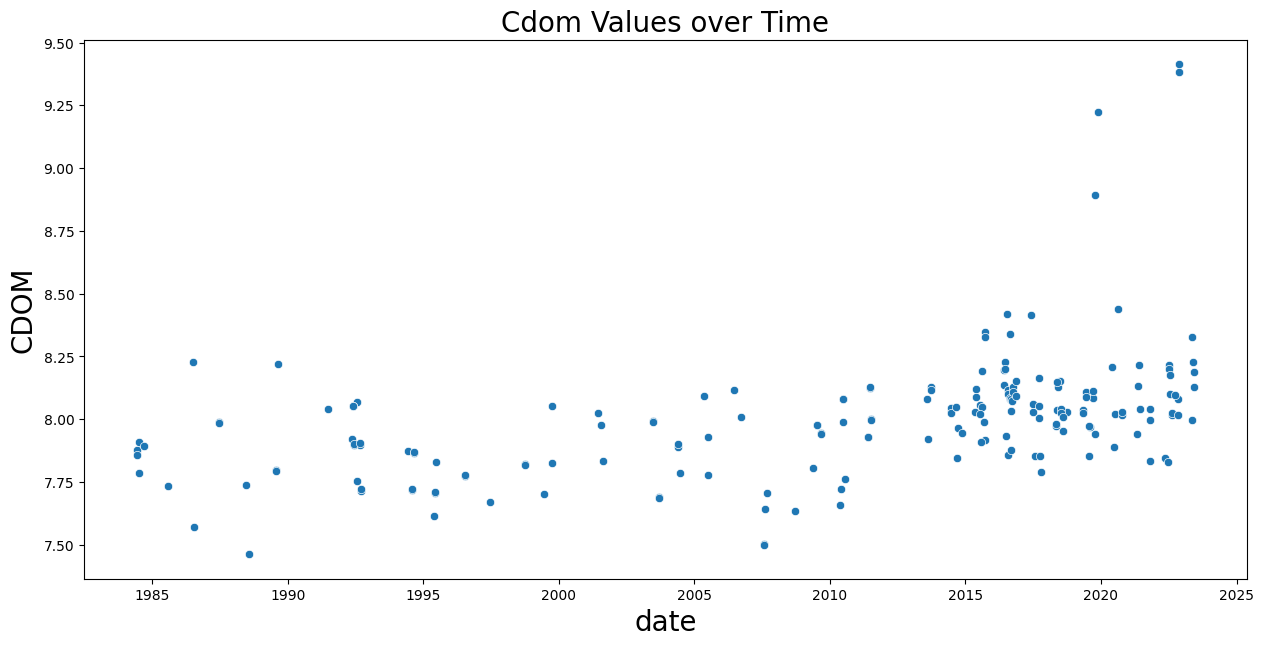

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
# Create a figure with subplots and set the dimensions to 15 x 7
fig, ax = plt.subplots(figsize=(15, 7))

# Create the plot by setting our dataframe to the data argument
sns.scatterplot(data=df, x='date', y='mean', ax=ax)

# Set the labels and title
ax.set_ylabel('CDOM', fontsize=20)
ax.set_xlabel('date', fontsize=20)
ax.set_title('Cdom Values over Time', fontsize=20)

# Format the x-axis tick labels to display only the year
# ax.xaxis.set_major_formatter(plt.FixedFormatter(df['date'].dt.year.unique()))

# Display the plot
plt.show()


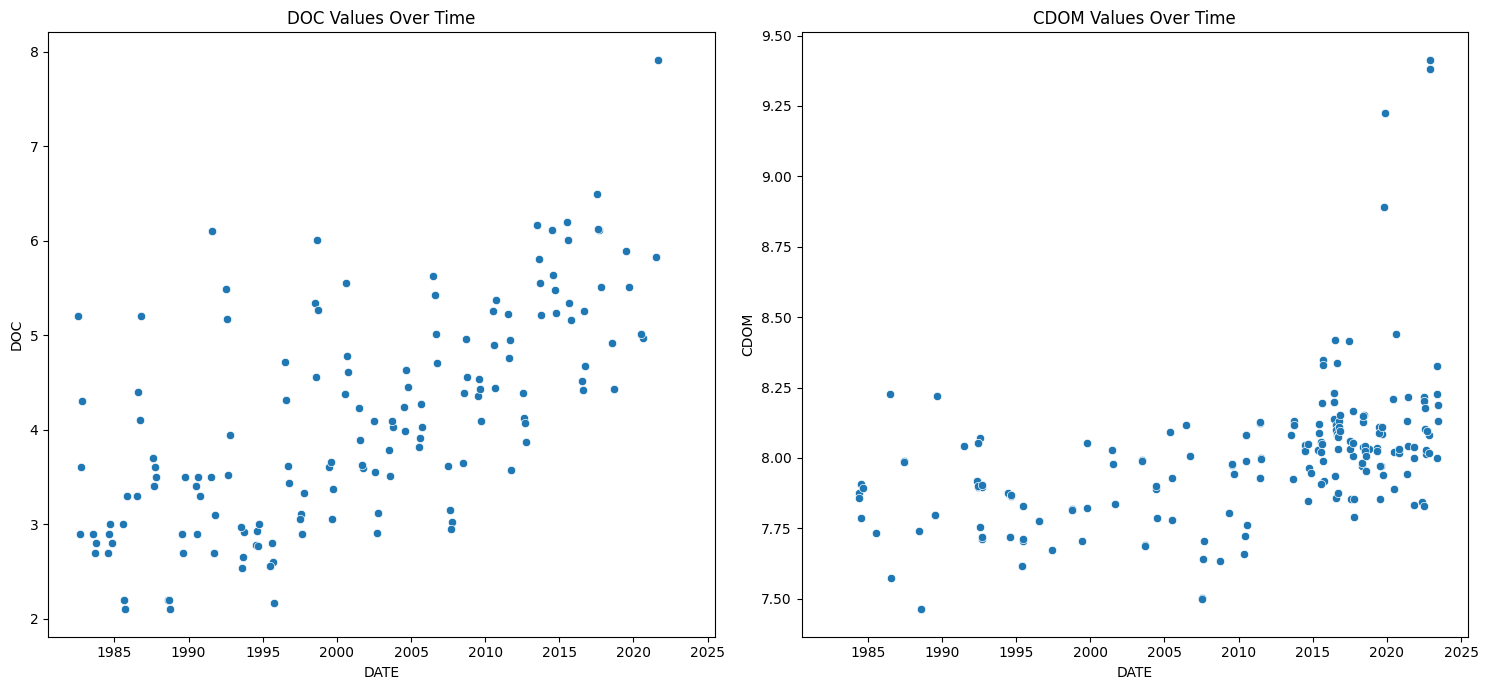

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7), sharex=True)

# Seaborn scatter plot
sns.scatterplot(data=data, x=data.index, y='DOC', ax=ax1)
ax1.set_xlabel('DATE')
ax1.set_ylabel('DOC')
ax1.set_title('DOC Values Over Time')

# Seaborn scatter plot
sns.scatterplot(data=df, x='date', y='mean', ax=ax2)
ax2.set_xlabel('DATE')
ax2.set_ylabel('CDOM')
ax2.set_title('CDOM Values Over Time')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


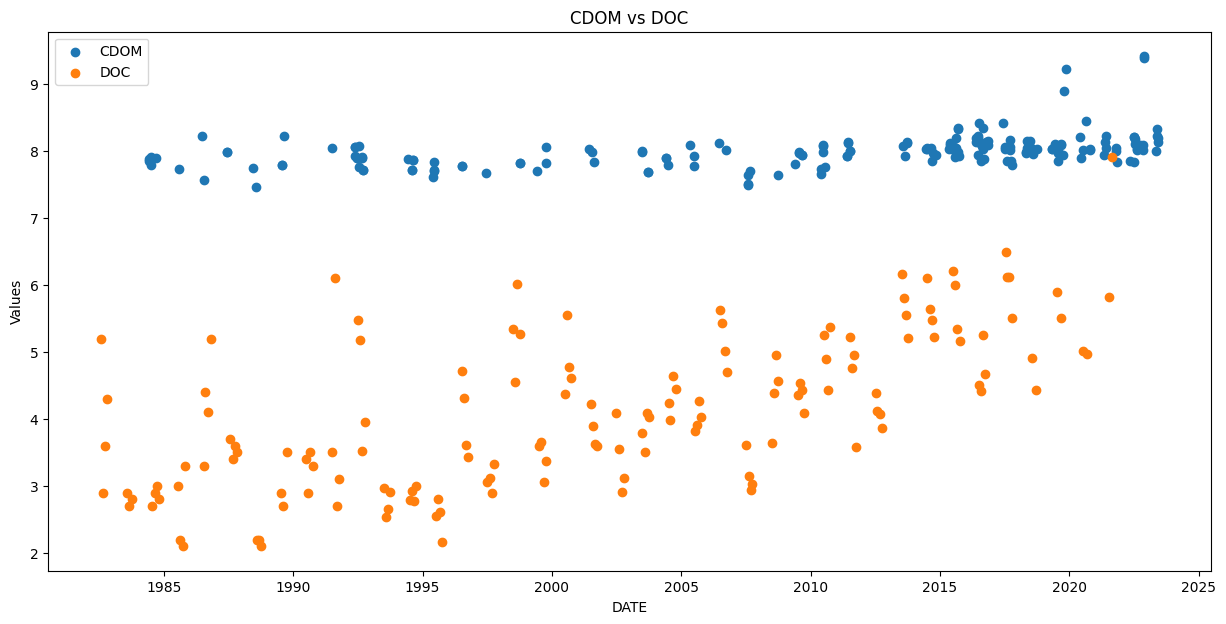

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure and an Axes object
fig, ax = plt.subplots(figsize=(15, 7))

# Matplotlib scatter plot
ax.scatter(df['date'], df['mean'], label='CDOM')

# Matplotlib scatter plot
ax.scatter(data.index, data['DOC'], label='DOC')

# Set the labels and title
ax.set_xlabel('DATE')
ax.set_ylabel('Values')
ax.set_title('CDOM vs DOC')

# Add a legend
ax.legend()

# Display the plot
plt.show()


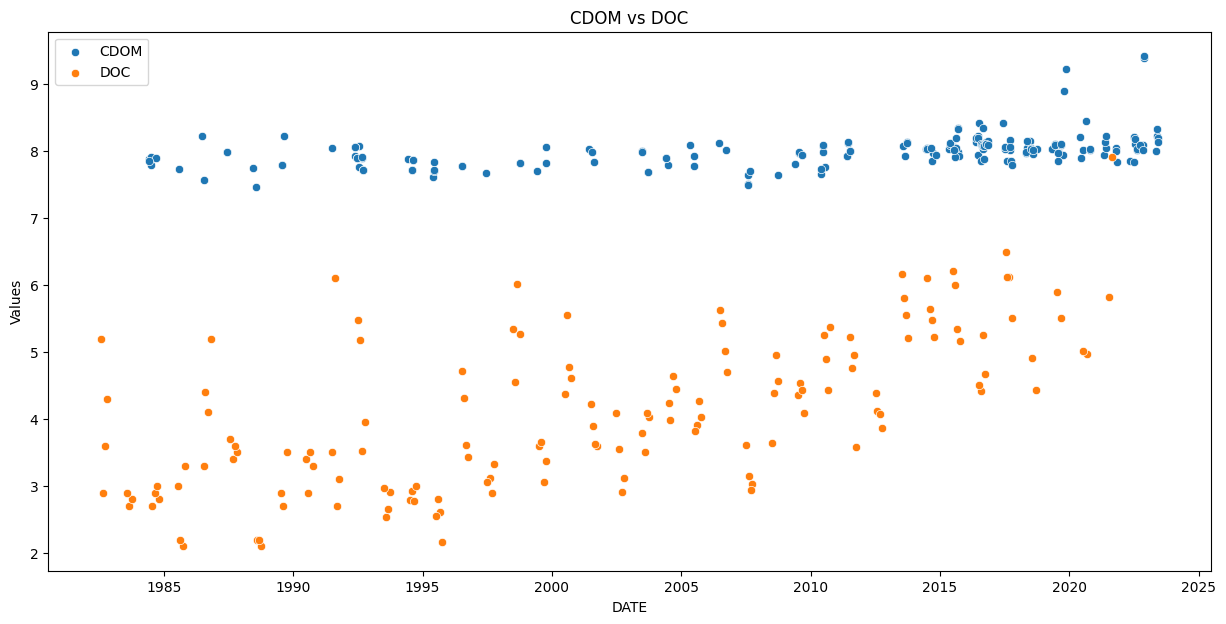

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure and an Axes object
fig, ax = plt.subplots(figsize=(15, 7))

# Seaborn scatter plots
sns.scatterplot(data=df, x='date', y='mean', ax=ax, label='CDOM')
sns.scatterplot(data=data, x='DATE', y='DOC', ax=ax, label='DOC')

# Set the labels and title
ax.set_xlabel('DATE')
ax.set_ylabel('Values')
ax.set_title('CDOM vs DOC')

# Add a legend
ax.legend()

# Display the plot
plt.show()


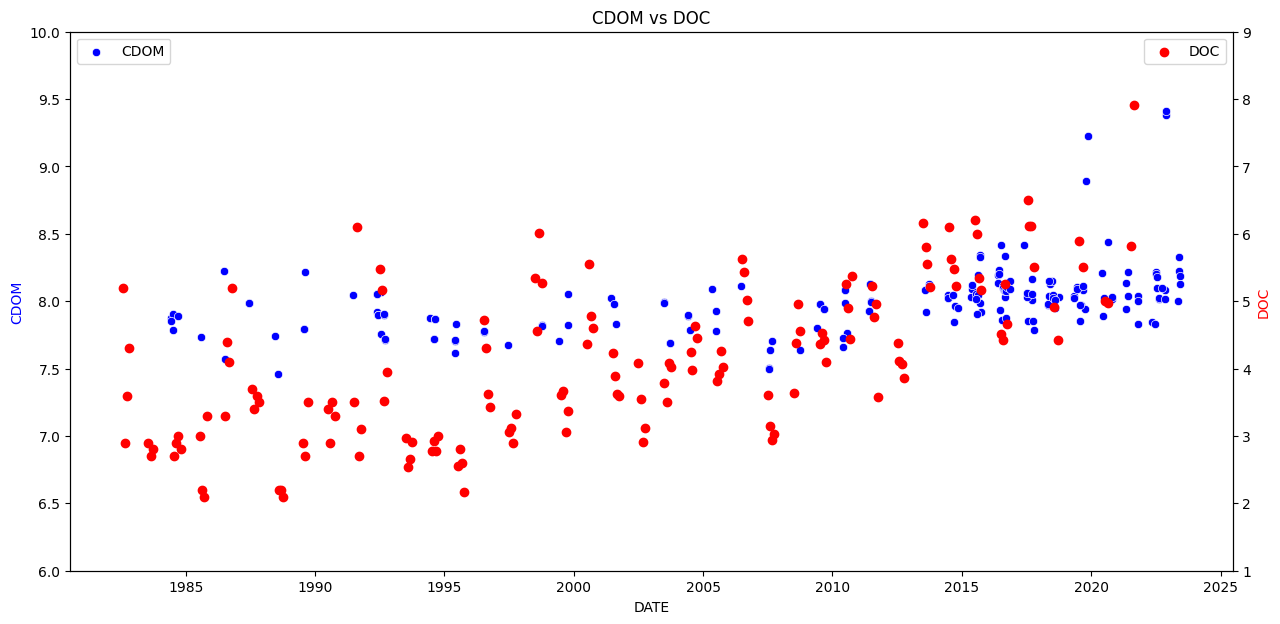

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure and an Axes object
fig, ax = plt.subplots(figsize=(15, 7))

# Seaborn scatter plot for CDOM
sns.scatterplot(data=df, x='date', y='mean', ax=ax, label='CDOM', color='blue')

# Create a twin Axes object for DOC
ax2 = ax.twinx()

# Matplotlib scatter plot for DOC
ax2.scatter(data.index, data['DOC'], label='DOC', color='red')

# Set the labels and title
ax.set_xlabel('DATE')
ax.set_ylabel('CDOM', color='blue')
ax2.set_ylabel('DOC', color='red')
ax.set_title('CDOM vs DOC')

# Set different ranges for the y-axes
ax.set_ylim(6, 10)  # Adjust the range for CDOM
ax2.set_ylim(1, 9)  # Adjust the range for DOC

# Add legends
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

# Display the plot
plt.show()
